# Выбор локации для скважины

Необходимо решить, где бурить новую скважину для нефтедобывающей компании.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Необходимо проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Импортируем необходимые в проекте модули

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from scipy import stats as st
from IPython.display import display

pd.set_option('display.max_columns', 50)
pd.set_option('display.precision', 3)

В целях уменьшения количества 0 и соответствия маштабу `целевого признака` поделим значения стоимости в рублях на `1000000`в константах:

In [2]:
#константы
STATE = np.random.RandomState(12345)
#необходимое для разработки количество скважин
WELLS_TOTAL = 500
#необходимое количество необходимых лучших скважин в регионе
WELLS_NUMBER = 200
#общий бюджет (расходы) по разработки скважин в регионе
REGION_BUDGET = 10_000_000_000 / 1_000_000
#бюджет для разработки 1 скважина в регионе
WELL_BUDGET = REGION_BUDGET / WELLS_NUMBER
#доход за продажу 1000 барелей нефти
REVENUE_1BAR = 450_000 /1_000_000
#количество баррелей для безубыточности разработк
BREAK_EVEN = WELL_BUDGET / REVENUE_1BAR 
#приемлемый уровень риска
LOSS_RISK = 0.025

### Загрузим данные и посмотрим первичную информацию

In [3]:
df_0, df_1, df_2 = (
    pd.read_csv(a) for a in ['/datasets/geo_data_0.csv', '/datasets/geo_data_1.csv', '/datasets/geo_data_2.csv']
)
df_0.name, df_1.name, df_2.name = 'region_0', 'region_1', 'region_2'
#список датафремов
df_list = [df_0, df_1, df_2]
print(f'{df_0.name} - {df_0.shape}\n{df_1.name} - {df_1.shape}\n{df_2.name} - {df_2.shape}')

region_0 - (100000, 5)
region_1 - (100000, 5)
region_2 - (100000, 5)


In [4]:
display(df_0.head(), df_1.head(), df_2.head())

,id,f0,f1,f2,product
0,txEyH,0.706,-0.498,1.221,105.280
1,2acmU,1.335,-0.340,4.365,73.038
2,409Wp,1.023,0.152,1.420,85.266
3,iJLyR,-0.032,0.139,2.979,168.621
4,Xdl7t,1.988,0.155,4.752,154.037


,id,f0,f1,f2,product
0,kBEdx,-15.001,-8.276,-0.006,3.179
1,62mP7,14.272,-3.475,0.999,26.953
2,vyE1P,6.263,-5.948,5.001,134.766
3,KcrkZ,-13.081,-11.506,4.999,137.945
4,AHL4O,12.702,-8.147,5.004,134.766


,id,f0,f1,f2,product
0,fwXo0,-1.147,0.963,-0.829,27.759
1,WJtFt,0.263,0.270,-2.530,56.070
2,ovLUW,0.195,0.289,-5.586,62.872
3,q6cA6,2.236,-0.554,0.930,114.573
4,WPMUX,-0.516,1.716,5.899,149.601


In [5]:
for data in df_list:
    display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

**Данные геологоразведки 3 регионов находятся в 3 таблицах:**
- geo_data_0.csv
- geo_data_1.csv
- geo_data_2.csv  

`id` — уникальный идентификатор скважины  
`f0`, `f1`, `f2` — три основных характеристики (признака) скважен   

**Целевой признак:**
`product` — объём запасов в скважине (тыс. баррелей).

В данных нет пропусков, типы данных и формат актуальны для анализа и машинного обучения.   



### Проанализируем данные и подготовим данные

Проверим уникальные значения признаков:

In [35]:
for data in df_list:
    display(data.nunique().to_frame(name=f'{data.name}').T)

,f0,f1,f2,product
region_0,99990,99990,99990,99990


,f0,f1,f2,product
region_1,99996,99996,99996,12


,f0,f1,f2,product
region_2,99996,99996,99996,99996


В столбце `'Уникальный идентификатор скважины'` (`id`), есть дубликаты. Проверим какие они хранят данные 

Так же обращает на себя внимание однообразие данных в данах df_1 признаке `product`, всего 12 разных значений против 100000 в двух других регионах.

In [7]:
display(df_1['product'].value_counts().to_frame().T)

,53.907,26.953,84.039,57.086,3.179,80.860,30.132,134.766,110.992,0.000,137.945,107.813
product,8472,8468,8431,8390,8337,8320,8306,8304,8303,8235,8233,8201


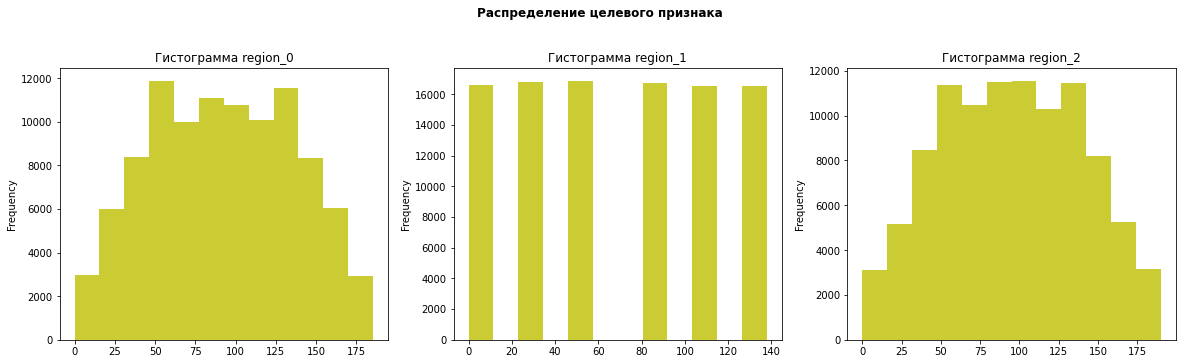

In [8]:
fig, axes = plt.subplots(1, 3, figsize = (20, 5))
fig.suptitle('Распределение целевого признака', fontsize = 12, fontweight='bold', y = 1.05)
for i, data in enumerate(df_list):
    data['product'].plot(kind='hist', bins=12, color='y', alpha=0.8, ax=axes[i], title=f'Гистограмма {data.name}')
plt.show()    

Распределение в `region_1` имеет отличичия от других распределений (`region_0 и region_2` имеют форму нормального распределения), и имеют всего **12 разных показателей запасов**, с примерно одинаковым количеством данных в каждом значении. Можно предположить, что данный распределение результат предобработки данных, вводных по этому поводу нет поэтому придеться работать с тем, что есть.

In [9]:
for data in df_list:
    print('Количество полных дубликатов -', data.duplicated().sum(), '\n')
    print('Дубликаты в столбце "id" (первые 5 строк):')
    display(data.loc[data['id'].duplicated(keep=False)].sort_values(by='id', ascending=False).head())    

Количество полных дубликатов - 0 

Дубликаты в столбце "id" (первые 5 строк):


,id,f0,f1,f2,product
90815,fiKDv,0.050,0.841,6.395,137.347
16633,fiKDv,0.157,1.028,5.586,95.818
41724,bxg6G,-0.824,0.546,3.630,93.008
1364,bxg6G,0.412,0.857,-3.653,73.604
97785,bsk9y,0.378,0.006,0.161,160.637


Количество полных дубликатов - 0 

Дубликаты в столбце "id" (первые 5 строк):


,id,f0,f1,f2,product
47591,wt4Uk,-9.091,-8.109,-0.002,3.179
82873,wt4Uk,10.260,-9.376,4.994,134.766
2721,bfPNe,-9.494,-5.464,4.006,110.992
82178,bfPNe,-6.203,-4.820,2.995,84.039
1305,LHZR0,11.171,-1.945,3.003,80.860


Количество полных дубликатов - 0 

Дубликаты в столбце "id" (первые 5 строк):


,id,f0,f1,f2,product
28039,xCHr8,1.633,0.368,-2.378,6.121
43233,xCHr8,-0.847,2.102,5.597,184.389
44378,Vcm5J,-1.229,-2.439,1.223,137.968
95090,Vcm5J,2.588,1.987,2.482,92.328
11449,VF7Jo,2.123,-0.858,5.746,181.717


Уникальные индентификационные номера не могут быть одинаковые, т.к. доля дубликатов не значительная, удалим дубликаты и лишний столбец `id`.   

Так же посмотрим на основные статистические показатели таблиц.

In [10]:
for data in df_list:
    data.drop_duplicates(subset='id', inplace=True)
    data.drop('id', axis=1, inplace=True)
    display(data.describe().T)

,count,mean,std,min,25%,50%,75%,max
f0,99990.0,0.500,0.872,-1.409,-0.073,0.502,1.074,2.362
f1,99990.0,0.250,0.504,-0.848,-0.201,0.250,0.701,1.344
f2,99990.0,2.503,3.248,-12.088,0.288,2.516,4.715,16.004
product,99990.0,92.500,44.288,0.000,56.497,91.848,128.564,185.364


,count,mean,std,min,25%,50%,75%,max
f0,99996.0,1.141,8.966,-31.610,-6.299,1.153,8.621,29.422
f1,99996.0,-4.797,5.120,-26.359,-8.268,-4.813,-1.333,18.734
f2,99996.0,2.495,1.704,-0.018,1.000,2.011,4.000,5.020
product,99996.0,68.824,45.945,0.000,26.953,57.086,107.813,137.945


,count,mean,std,min,25%,50%,75%,max
f0,99996.0,0.002,1.732,-8.760,-1.162,0.009,1.158,7.238
f1,99996.0,-0.002,1.730,-7.084,-1.175,-0.010,1.164,7.845
f2,99996.0,2.495,3.473,-11.970,0.130,2.484,4.859,16.739
product,99996.0,94.998,44.750,0.000,59.450,94.925,130.587,190.030


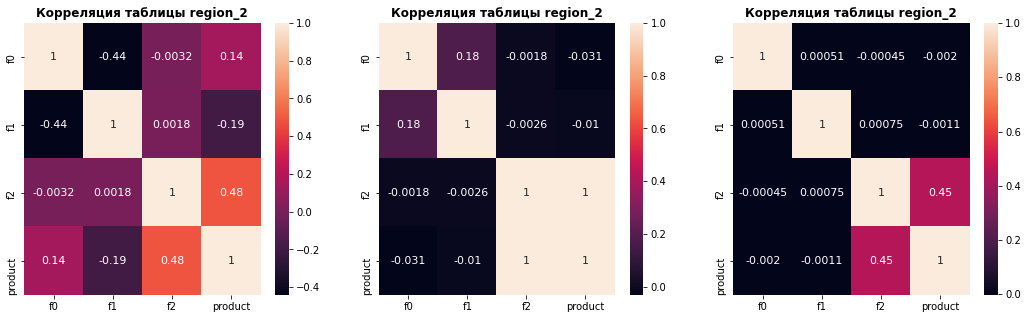

In [11]:
plt.figure(figsize = (18,5))
for i, s in enumerate([131, 132, 133]):
    plt.subplot(s)
    sns.heatmap(df_list[i].corr(), annot=True, annot_kws={'size' : 11})
    plt.title(f'Корреляция таблицы {data.name}', fontweight="bold")

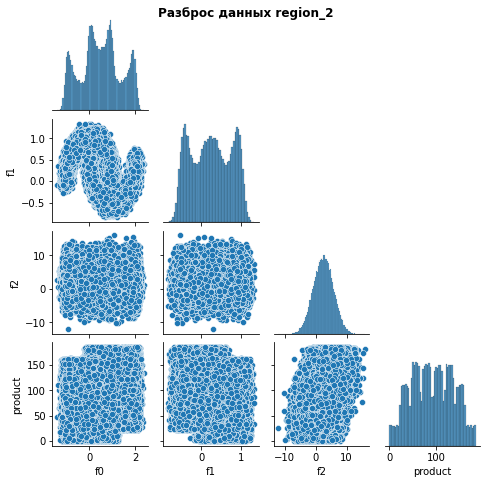

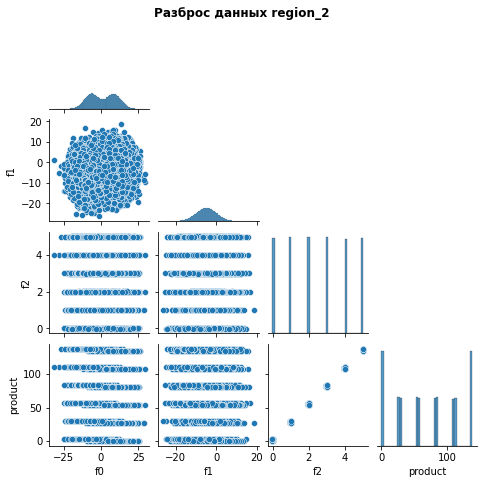

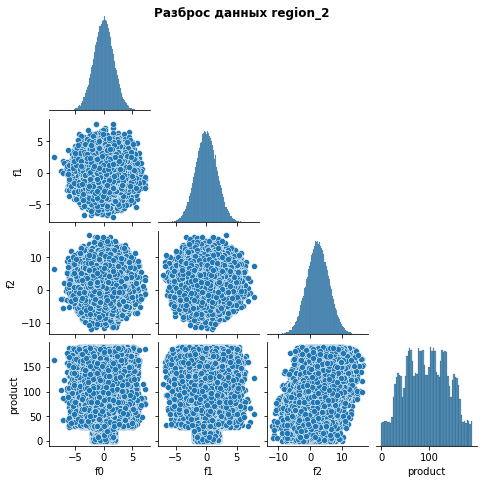

In [12]:
for df in df_list:
    sns.pairplot(df, height=1.7, corner=True)
    plt.suptitle(f'Разброс данных {data.name}', fontweight="bold")
    plt.show()

Сильная зависимость целевого признака `product` с признаком `f2` в особенно в `regione_1`, еще раз убеждаемся в неестественном распределении данных в данном регионе.  

Так же наблюдается отрицательная зависимость между признаками `f0` и `f1` особенно в `df_0`, однако не достаточная для мультикорелиальности и удаления признака из датайрема.

Имеет целесообразность исследовать обучение модели в том числе на обобщенных тренировочных данных, т.к. скважины уникальны, и признаки одинаковы для всех регионов.  

Так же на основании анализа данных выдвинем и проверим гипотезу:  
 - Так как основные признаки f0, f1, f1 имеют одинаковые характеристики, предположим, что модель обученная на объедененных тренировочных данных всех 3 регионов, даст лучшие оценки R2 и низкие RMSE на валидационных данных регионов, если данные будут лучше, то будем использовать для всех модель обученную на объедененной выборке, в противном случае, будет использовать модели обученные на данных конкретного региона.  

## Обучение и проверка модели

### Деление данных на выборки для дальнейшего исследования

Разделим данные на основные и целевой признаки

In [13]:
features_0, features_1, features_2, = (data.drop('product', axis=1) for data in df_list)
target_0, target_1, target_2 = (data['product'] for data in df_list)

Разделим основные и целевоые признаки на тренировочную и валидационную выборки

In [14]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(
    features_0, target_0, test_size=0.25, random_state=STATE
)
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1, target_1, test_size=0.25, random_state=STATE
)
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2, target_2, test_size=0.25, random_state=STATE
)

#объеденим тренировочную выборку и целевой признак
features_train_all, target_train_all = (
    pd.concat([features_train_0, features_train_1, features_train_2]), 
    pd.concat([target_train_0, target_train_1, target_train_2])
)

### Обучение моделей на тренировочных данных и ее оценка.

In [15]:
#крос-валидация
def cv_scores(*valid, model, features_t, target_t):
    scores = cross_val_score(model, features_t, target_t, cv=5)
    print('Средняя оценка качества модели при CV:', np.mean(scores))
    print('Стандартное отклонение модели при CV:', np.std(scores))
    for valid_data in valid:
        print('Оценка качества модели на валидационных данных -', 
              model.score(valid_data[0], valid_data[1]))
    

In [16]:
#Создаем датафрейм с данными rsme и средними объемами
df_total = pd.DataFrame(columns=['model_name', 'rmse', 'target_mean', 'predicted_mean'])
def rmse_helper(target, predicted, model_name):
    df_new = pd.DataFrame()    
    for i, tar_v in enumerate(target):
        rmse = mean_squared_error(tar_v, predicted[i])**0.5
        
        target_mean = tar_v.mean()
        predicted_mean = predicted[i].mean()
        
        df_new = pd.concat(
            [df_new, pd.DataFrame([[model_name[i], rmse, target_mean, predicted_mean]], columns=df_total.columns)], 
            ignore_index=True
        )    
    
    return df_new

In [17]:
#Создает графики бары с показателями в разрезе столбцов 
def plot_helper(df, table_name, columns=[], ind=True):
           
    if ind:
        df.plot(kind='bar', x='model_name', grid=True, rot=1, figsize=(10, 5))
        plt.title(table_name, fontweight='bold')
        plt.legend(bbox_to_anchor=(1,1), loc='upper left')
        plt.show()
        
        display(df.set_index('model_name').T)
    else:
        df = df.set_index(columns[0])
        
        fig, axes = plt.subplots(1, 3, figsize = (14, 7))
        fig.suptitle(table_name, fontsize = 12, fontweight='bold', y = 1)
        df[columns[1]].plot(
            kind='bar', grid=True, color='y', rot=1, ax=axes[0], title=f'Таблица {columns[1]}')
        df[columns[2]].plot(
            kind='bar', grid=True, color='g', rot=1, ax=axes[1], title=f'Таблица {columns[2]}')
        df[columns[3]].plot(
            kind='bar', grid=True, color='r', rot=1, ax=axes[2], title=f'Таблица {columns[3]}')
        plt.show()
        
        display(df)
        

In [18]:
model_0 = LinearRegression().fit(features_train_0, target_train_0)
cv_scores([features_valid_0, target_valid_0],
          model=model_0, 
          features_t=features_train_0, 
          target_t=target_train_0, 
         )

Средняя оценка качества модели при CV: 0.27659260309400285
Стандартное отклонение модели при CV: 0.006073072884342379
Оценка качества модели на валидационных данных - 0.2723923460817068


In [19]:
model_1 = LinearRegression().fit(features_train_1, target_train_1)
cv_scores([features_valid_1, target_valid_1],
          model=model_1, 
          features_t=features_train_1, 
          target_t=target_train_1
         )

Средняя оценка качества модели при CV: 0.9996261381294126
Стандартное отклонение модели при CV: 5.114395269104085e-06
Оценка качества модели на валидационных данных - 0.9996189787138543


In [20]:
model_2 = LinearRegression().fit(features_train_2, target_train_2)
cv_scores([features_valid_2, target_valid_2], model=model_2, features_t=features_train_2, target_t=target_train_2)

Средняя оценка качества модели при CV: 0.19781481364947187
Стандартное отклонение модели при CV: 0.003013767024862385
Оценка качества модели на валидационных данных - 0.2012463721981833


In [21]:
model_all = LinearRegression().fit(features_train_all, target_train_all)
cv_scores([features_valid_0, target_valid_0], 
          [features_valid_1, target_valid_1], 
          [features_valid_2, target_valid_2],
          model=model_all, 
          features_t=features_train_all, 
          target_t=target_train_all, )

Средняя оценка качества модели при CV: 0.2360248345247503
Стандартное отклонение модели при CV: 0.10315837397704171
Оценка качества модели на валидационных данных - 0.18953601647891216
Оценка качества модели на валидационных данных - 0.4448781550758777
Оценка качества модели на валидационных данных - 0.12830747730753023


Оценки модели обученные на данных `region_0` и `region_2` показали низкую оценку **`R2`** на теринировочных и валидационных данных, но показали низкое `STD`, что говорит о низкой переобучаемости моделей.   
`region_1` в свою очередь показал почти 100% оценку **`R2`** и довольно высокой `STD`, в реальности такое очень сложно повстречать.

Модель обученная на объедененных данных показала худшие оценки по **`R2`** во всех регионах.


Оценка качества модели на валидационных данных - 0.12830747730753023

### Предсказания моделей

In [22]:
#предсказания на моделях в разрезе регионов
predicted_0, predicted_1, predicted_2 = (model_0.predict(features_valid_0),
                                         model_1.predict(features_valid_1),
                                         model_2.predict(features_valid_2))

#предсказания для модели обученой на общей выборке
predicted_all_0, predicted_all_1, predicted_all_2 =(model_all.predict(features_valid_0),
                                                    model_all.predict(features_valid_1),
                                                    model_all.predict(features_valid_2))

Так как выборки были исскуственно синтезированны, есть вероятность не корректных предсказаний, проверим наличие отрицательных значений в предсказаниях запасов нефти. Если такие значения обнаружаться заменим их на 0, т.к. отрицательные данные мы не сможем использовать в работе и они могут исказить дальнейшее исследование.

In [23]:
print('До удаления в следующих предсказаниях было отрициательных значений:')
for i, res in enumerate([predicted_0, predicted_1, predicted_2, predicted_all_0, predicted_all_1, predicted_all_2]):
    array_name = ['predicted_0', 'predicted_1', 'predicted_2', 'predicted_all_0', 'predicted_all_1', 'predicted_all_2']
    negative = res[res < 0]
    if negative.any():
        print(f'{array_name[i]} - {negative.size} шт.')
        res[res < 0] = 0

До удаления в следующих предсказаниях было отрициательных значений:
predicted_0 - 1 шт.
predicted_1 - 543 шт.
predicted_all_0 - 6 шт.
predicted_all_2 - 31 шт.


### Результаты предсказаний моделей по регионам

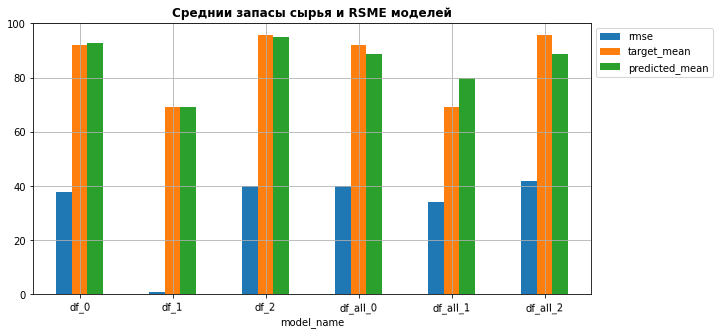

model_name,df_0,df_1,df_2,df_all_0,df_all_1,df_all_2
rmse,37.853,0.890,40.042,39.948,34.154,41.811
target_mean,92.158,68.970,95.517,92.158,68.970,95.517
predicted_mean,92.790,68.968,95.079,88.547,79.793,88.499


In [24]:
df_total = rmse_helper(
    target=[target_valid_0, target_valid_1, target_valid_2, target_valid_0, target_valid_1, target_valid_2], 
    predicted=[predicted_0, predicted_1, predicted_2, predicted_all_0, predicted_all_1, predicted_all_2], 
    model_name=['df_0', 'df_1', 'df_2', 'df_all_0', 'df_all_1', 'df_all_2']
) 

plot_helper(df_total, 'Среднии запасы сырья и RSME моделей')

Лучшая модель по оценки `RSME` так же модель `region_1` на своей тренировочной выборке. Тем не менее количество запасов сырья в `region_0 и region_2` больше чем в `region_1`. Среднии объемы предсказанного сырья соотвествуют целевым.  Оценка `RSME` в `region_0 и region_2` показали меньшую среднеквадратическую ошибку чем на моделях обученных на общей выборке (`df_all_0, df_all_1, df_all_2`).

Выдвинутая гипотеза о том, что модели обученные на больших данных (объедененных тренировочных данных), покажут лучшие результаты на оправдалась.

## Подготовка к расчёту прибыли

### Расчет и визуализация средних запасов в регионе

Все константы выенесены в начала проекта, в целях быстрого нахождениях их в проекте.

Удалим столбец со значением RMSE и добавим столбец с достаточным объемом для безубыточности разработки нефтяной скважины. Так же удалим строки со значениями обученых на обобщенных данных.

In [25]:
df_total = df_total.query('model_name not in ["df_all_0", "df_all_1", "df_all_2"]')
df_total = df_total.drop('rmse', axis=1)
df_total['break_even'] = BREAK_EVEN

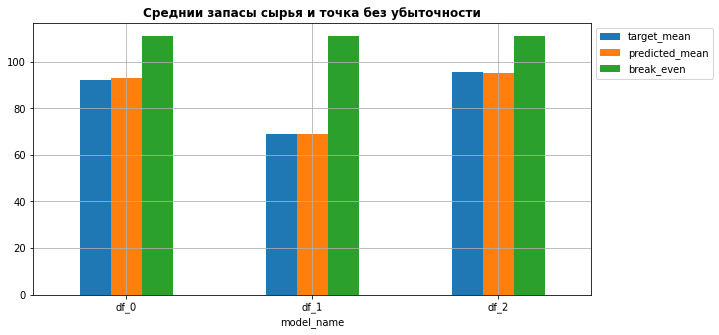

model_name,df_0,df_1,df_2
target_mean,92.158,68.970,95.517
predicted_mean,92.790,68.968,95.079
break_even,111.111,111.111,111.111


In [26]:
plot_helper(df_total, 'Среднии запасы сырья и точка без убыточности')

Точка без убыточности `BREAK_EVEN` равна `111.111` тыс. баррелей.  
Во всех регионах среднии показатели запасов сырья ниже необходимого объема, для безубыточной разработки скважин. Самые большие среднии запасы в `region_2`, чуть меньше в `region_0`. А в `region_1` самый низкий запас сырья. Во всех 3 регионах среднии запасы сырья не достаточны для безубыточной разработки. А учитывая низкие оценки предсказывания моделей по 2 регионам, нужно аккуратно подходить к выбору.

## Расчёт прибыли и рисков 

### Напишем расчитаем прибыль по выбранным максимальным предсказаниям для каждого региона

Напишем функцию для расчета прибыли

In [27]:
def profit(*predicted, target, is_frame=True):
    profitability = pd.DataFrame()
    for i, pred in enumerate(predicted):
        target_new = target[i].reset_index(drop=True) 
        target_pred = target_new[np.argsort(pred)[::-1]][:WELLS_NUMBER]
        
        income_forecast = sum([v * REVENUE_1BAR for v in target_pred])
 
        profitability = pd.concat(
            [profitability, 
             pd.DataFrame(
                 [[df_list[i].name,
                   target_pred.sum(),
                   BREAK_EVEN, REGION_BUDGET, 
                   income_forecast, 
                   income_forecast - REGION_BUDGET]],
                 columns=['region', 'product', 'break_even', 'costs', 'income_forecast', 'profit_forecast'])], 
            ignore_index=True)
    
    if is_frame:
        return profitability
    else:
        return profitability['profit_forecast'][0]

In [28]:
#массив который хранит валидационные выборки с оновленными индексами
target_array = [t.reset_index(drop=True) for t in [target_valid_0, target_valid_1, target_valid_2]]

In [29]:
df_profit = profit(predicted_0, predicted_1, predicted_2, target=target_array)

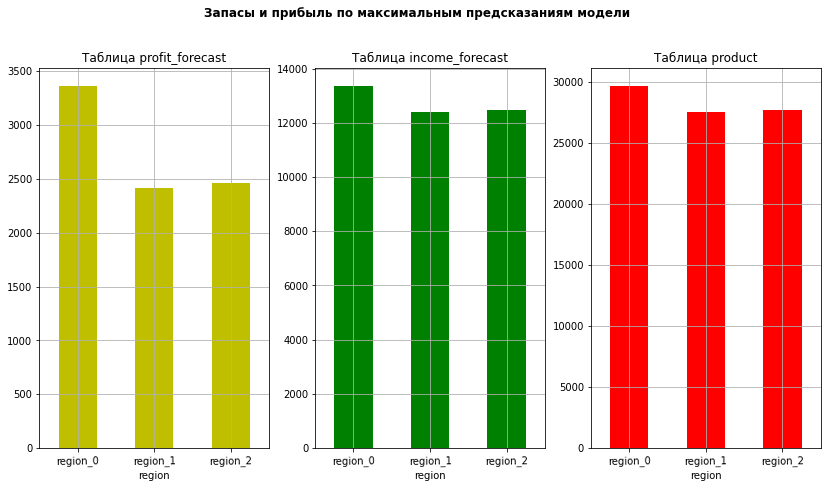

,product,break_even,costs,income_forecast,profit_forecast
region,,,,,
region_0,29700.416,111.111,10000.0,13365.187,3365.187
region_1,27589.082,111.111,10000.0,12415.087,2415.087
region_2,27684.734,111.111,10000.0,12458.130,2458.130


In [30]:
plot_helper(df_profit, 
            table_name='Запасы и прибыль по максимальным предсказаниям модели', 
            columns=['region', 'profit_forecast', 'income_forecast', 'product'],
            ind=False)

В случае если мы выбираем максимальные значения по запаса в скважинах, то получаем оптимистичный проноз прибыли во всех 3 регионах, где самая большая доходность будет в `region_0`. 

Однако на основании выборок которые нам предоставили и условий исследования, мы получили 2 модели с не очень выской точностью, поэтому есть очень значительные риски ошибиться с выбором, потому для более точной оценки потенциальной прибыли и рисков используем метод `Bootstrap`.   


### Оценка рисков и прибыли для каждого региона


Выберем 500 лучших скважин по запасам предсказаний и исползуя `Bootstrap` найдем 200 самых лучших по прибыли скважин для разработки.

In [31]:
def bootstrap_profit_risc(*predicted, target):
    df = pd.DataFrame()
    for i, pred in enumerate(predicted):
        values = list()
        for j in range(1000):
            target_subsample = target[i].sample(n=WELLS_TOTAL, replace=True, random_state=STATE)
            probs_subsample = pred[target_subsample.index]
        
            values.append(profit(probs_subsample, target=[target_subsample], is_frame=False))
       
        values = pd.Series(values)
        upper = values.quantile(1 - LOSS_RISK)
        lower = values.quantile(LOSS_RISK)
        mean = values.mean()
        confidence_interval = st.t.interval(0.95, values.size - 1, values.mean(), values.sem())
    
        df = pd.concat([df, pd.DataFrame(
            [[df_list[i].name, mean, upper, lower, confidence_interval, (values < 0).mean() * 100]],
            columns=['region', 'mean_revenue', '97.5_quantile', '2.5_quantile', 'confidence_interval', 'risk']
        )], ignore_index=True)

    return df
    

In [32]:
df_profit = bootstrap_profit_risc(predicted_0, predicted_1, predicted_2, target=target_array)

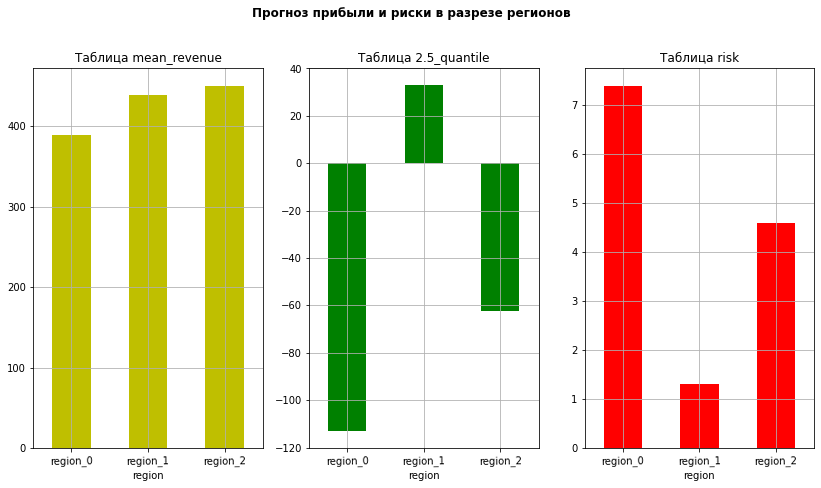

,mean_revenue,97.5_quantile,2.5_quantile,confidence_interval,risk
region,,,,,
region_0,389.044,894.001,-112.966,"(372.69599729577686, 405.39297981839326)",7.4
region_1,439.072,850.148,33.065,"(426.75912048944707, 451.38565654201255)",1.3
region_2,450.225,943.656,-62.394,"(433.96822717610445, 466.4811998445845)",4.6


In [33]:
plot_helper(df_profit, 
            table_name='Прогноз прибыли и риски в разрезе регионов', 
            columns=['region', 'mean_revenue', '2.5_quantile', 'risk'],
            ind=False)

Как и предпологалось при оценки прибыли по максимальным показателям существуют большие риски при расчете только на предсказания модели и отбор по максимальным прогнозам.

## Общий вывод

Данное исследование было реализовано, с целью определения региона, где добыча нефти принесёт наибольшую прибыль компании и анализа возможной прибыли и рисков техникой `Bootstrap`.

Входные данные - синтетические данные геологоразведки трёх регионов, в каждом по 100 000 строк и 5 столбцов.

**Цель проекта**:

 - Построить модели для предсказания объёма запасов в новых скважинах;
 - Выбирать скважины с самыми высокими оценками значений;
 - Определить регион с максимальной суммарной прибылью отобранных скважин и возможные риски убытков.
 
 
 **Основные шаги по проекту**:
 - *В ходе исследования была подготовлены и проанализированы выборки, обнаружены аномальное распределение и значения в регионе 1*
 - *Выдвинута и опровергнта промежуточная гипотеза,  о том что на объедененных данных будут лучшии оценки модели на валидационной выборке*  
 - *Были обучены модели Linear Regession на выборках 3 регионов*
 - *Расчитаны основные экономические показатели для оценки прибыльности и рисков убытков*
 - *Произведен расчет потеницальной прибыли и возможных рисков, а так же сравнения мжду регионами*    
 
 
**В результате исследования**:  
 
 Был выявлен регион с лучшими показателями проноза прибыли и минимальных рисков (менее 2,5%) 
 

In [36]:
display(df_profit.query('region == "region_1"'))

,region,mean_revenue,97.5_quantile,2.5_quantile,confidence_interval,risk
1,region_1,439.072,850.148,33.065,"(426.75912048944707, 451.38565654201255)",1.3


Так же было выялено, то что поиск по максимальным прогнозам и выбором скважин имеет серезный недостаток и несет в себе высокие риски. Необходимо дополнительно проверять и расчитывать прогнох прибыли и рисков использую Беггинг и ругие методы.

**Рекомендации**:  

Аномальные значения и распределение оказало существенное влияние на прогнозы и результаты исследования. Необходимо перепроверить синтетические данные. И в случае их актуальности и репрезентативности, операться на результаты исследования. В противном случае необходимо осуществить дополнительный анализ и расчеты с уточненными данными по региону 2.
